In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
!ln -s /content/gdrive/MyDrive/ /mydrive
!ls /mydrive

ln: failed to create symbolic link '/mydrive': File exists
/mydrive


In [4]:
!ls

drive  sample_data


In [5]:
%cd ..

/


In [6]:
!ls

bin	 dev   lib32  mydrive			python-apt  srv    usr
boot	 etc   lib64  NGC-DL-CONTAINER-LICENSE	root	    sys    var
content  home  media  opt			run	    tmp
datalab  lib   mnt    proc			sbin	    tools


In [7]:
%cd content/drive/MyDrive/Colab Notebooks/Netflix_Movie_Recommendation

/content/drive/MyDrive/Colab Notebooks/Netflix_Movie_Recommendation


In [8]:
from datetime import datetime 
# globalstart = datetime.now()
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.linalg import sqrtm

from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [ ]:
!ls

In [ ]:
!unzip data_folder/archive.zip

Archive:  data_folder/archive.zip
  inflating: README                  
  inflating: combined_data_1.txt     
  inflating: combined_data_2.txt     
  inflating: combined_data_3.txt     
  inflating: combined_data_4.txt     
  inflating: movie_titles.csv        
  inflating: probe.txt               
  inflating: qualifying.txt          


In [ ]:
start = datetime.now()
if not os.path.isfile('data.csv'):
    # Creating a file 'data.csv' before reading it
    # Read all the files in netflix and store them in one big file('data.csv')
    # We re reading from each of the four files and appendig each rating to a global file 'train.csv'
    data = open('data.csv', mode='w')
    
    row = list()
    files=['data_folder/combined_data_1.txt','data_folder/combined_data_2.txt', 
           'data_folder/combined_data_3.txt', 'data_folder/combined_data_4.txt']

    for file in files:

        print("Reading ratings from {}...".format(file))

        with open(file) as f:
            for line in f: 
                del row[:] # We might not have to do this.
                line = line.strip()
                if line.endswith(':'):
                    # All below are ratings for this movie, until another movie appears.
                    movie_id = line.replace(':', '')
                else:
                    row = [x for x in line.split(',')]
                    row.insert(0, movie_id)
                    data.write(','.join(row))
                    data.write('\n')
        print("Done.\n")

    data.close()

print('Time taken :', datetime.now() - start)

Time taken : 0:00:00.000698


In [10]:
print("creating the dataframe from data.csv file..")
df = pd.read_csv('data.csv', sep=',', names=['movie', 'user','rating','date'])
df.date = pd.to_datetime(df.date)
print('Done.\n')

# we are arranging the ratings according to time.
print('Sorting the dataframe by date..')
df.sort_values(by='date', inplace=True)
print('Done..')

creating the dataframe from data.csv file..
Done.

Sorting the dataframe by date..
Done..


In [ ]:
df['user'].describe()

count    1.004805e+08
mean     1.322489e+06
std      7.645368e+05
min      6.000000e+00
25%      6.611980e+05
50%      1.319012e+06
75%      1.984455e+06
max      2.649429e+06
Name: user, dtype: float64

In [13]:
len(df2)

364225

<h2>Spliting data into Train and Test(80:20) </h2>

In [ ]:
if not os.path.isfile('train.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[:int(df.shape[0]*0.80)].to_csv("train.csv", index=False)

if not os.path.isfile('test.csv'):
    # create the dataframe and store it in the disk for offline purposes..
    df.iloc[int(df.shape[0]*0.80):].to_csv("test.csv", index=False)

train_df = pd.read_csv("train.csv", parse_dates=['date'])
test_df = pd.read_csv("test.csv")

In [ ]:
len(train_df2)

100480507

In [35]:
from collections import defaultdict
import json
def create_movie_user_dict_train(df):

    if not os.path.isfile('movie_user_train.json'):
        movie_user = defaultdict(list)
        # count=0
        for iter, row in df.iterrows():
            # count+=1
            # if count%10000==0:
            #   print(count)
            movie_user[row[0]].append(row[1])
        my_json = json.dumps(movie_user)
        f = open("movie_user_train.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('movie_user_train.json') as json_file:
          movie_user = json.load(json_file)
    print('movie_user_train.json loaded')
    return movie_user

def create_user_movie_dict_train(df):

    if not os.path.isfile('user_movie_train.json'):
        user_movie = defaultdict(list)
        for iter, row in df.iterrows():
            user_movie[row[1]].append(row[0])
        my_json = json.dumps(user_movie)
        f = open("user_movie_train.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('user_movie_train.json') as json_file:
          user_movie = json.load(json_file)
    print('user_movie_train.json loaded')
    return user_movie

def create_movie_user_dict_test(df):

    if not os.path.isfile('movie_user_test.json'):
        movie_user = defaultdict(list)
        for iter, row in df.iterrows():
            movie_user[row[0]].append(row[1])
        my_json = json.dumps(movie_user)
        f = open("movie_user_test.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('movie_user_test.json') as json_file:
          movie_user = json.load(json_file)
    print('movie_user_test.json loaded')
    return movie_user

def create_user_movie_dict_test(df):

    if not os.path.isfile('user_movie_test.json'):
        user_movie = defaultdict(list)
        for iter, row in df.iterrows():
            user_movie[row[1]].append(row[0])
        my_json = json.dumps(user_movie)
        f = open("user_movie_test.json","w")
        f.write(my_json)
        f.close()
    else:
        print("opening json file")
        with open('user_movie_test.json') as json_file:
          user_movie = json.load(json_file)
    print('user_movie_test.json loaded')
    return user_movie

In [33]:
import gc
gc.collect()

31

In [36]:
movie_user_train = create_movie_user_dict_train(train_df)
gc.collect()

movie_user_train.json loaded


0

In [37]:
movie_user_train['10341']

[]

In [38]:
user_movie_train = create_user_movie_dict_train(train_df)
gc.collect()

user_movie_train.json loaded


0

In [39]:
movie_user_test = create_movie_user_dict_test(test_df)
gc.collect()

movie_user_test.json loaded


0

In [40]:
user_movie_test = create_user_movie_dict_test(test_df)
gc.collect()

user_movie_test.json loaded


0

In [ ]:
df.head()

,movie,user,rating,date
56431994,10341,510180,4,1999-11-11
9056171,1798,510180,5,1999-11-11
58698779,10774,510180,3,1999-11-11
48101611,8651,510180,2,1999-11-11
81893208,14660,510180,2,1999-11-11


In [ ]:
result_comparision={'HR':[],'NDCG':[]}

In [ ]:
train_df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


In [75]:
from random import shuffle
import warnings
warnings.simplefilter('error', RuntimeWarning)
class SVD:  
    def __init__(self,movie_user,user_movie,K=30):  
        self.movie_user=movie_user 
        self.user_movie=user_movie 
        self.K=K  
        self.bi={}  
        self.bu={}  
        self.qi={}  
        self.pu={}  
        for user_id in list(user_movie.keys()): 
            uid=user_id
            self.bu.setdefault(uid,0)
            self.pu.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))
        for movie_id in list(movie_user.keys()):
            iid=movie_id  
            self.bi.setdefault(iid,0)   
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
    
    def Sort_Tuple(self,tup,n): #sort according to n+1 th item, the scores calculated
      tup.sort(key = lambda x: x[n], reverse=True)
      return tup

    def predict(self,uid,iid):  #预测评分的函数  
        #setdefault的作用是当该用户或者物品未出现过时，新建它的bi,bu,qi,pu，并设置初始值为0  
        self.bi.setdefault(iid,0)  
        self.bu.setdefault(uid,0)  
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu.setdefault(uid,np.zeros((self.K,1)))  
        rating=self.bi[iid]+self.bu[uid]+np.sum(self.qi[iid]*self.pu[uid]) #预测评分公式  
        return 1/(1 + np.exp(-rating))
      
    def train(self,user_movie,movie_user,steps=20,gamma=0.01,Lambda=0.03):  #训练函数，step为迭代次数。  
        num_user=len(list(user_movie.keys()))
        for step in range(steps):  
            print('step',step+1,'is running')  
            users_random=np.random.permutation(list(user_movie.keys())) #随机梯度下降算法，kk为对user_movie的keys进行随机洗牌
            movies=list(movie_user.keys())
            HR_num=0
            NDCG_total=0
            for user_id in users_random: 
              uid=user_id
              movie_list=[]
              watched_list=user_movie[uid].copy()
              watched_list=[str(i) for i in watched_list]
              the_one=watched_list.pop()
              unwatched_list=[]
              count=0
              while(count<100):
                selection=random.choice(movies)
                if selection in watched_list:
                  continue
                else:
                  unwatched_list.append(selection)
                  count+=1
              for movie in watched_list:
                movie_list.append((movie,1))
              for movie in unwatched_list:
                movie_list.append((movie,0))
              shuffle(movie_list)
              # print(movie_list)
              # print(" ")
              movie_list_new=[]
              for movie_rating in movie_list:  
                iid=movie_rating[0]
                rating=movie_rating[1]
                y_proba=self.predict(uid, iid)
                movie_list_new.append((iid,rating,y_proba))
                eui=rating-y_proba
                self.bu[uid]+=gamma*(eui-Lambda*self.bu[uid])    
                self.bi[iid]+=gamma*(eui-Lambda*self.bi[iid])  
                tmp=self.qi[iid]  
                self.qi[iid]+=gamma*(eui*self.pu[uid]-Lambda*self.qi[iid])  
                self.pu[uid]+=gamma*(eui*tmp-Lambda*self.pu[uid]) 

              sorted_IDCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_IDCG,1)
              sorted_DCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_DCG,2)
              # print(user_id)
              # print(sorted_IDCG)
              # print(sorted_DCG)
              the_one_score=self.predict(uid, the_one)
              # print(the_one_score)
              if the_one_score>sorted_DCG[9][2]:
                HR_num+=1
                DCG=0
                IDCG=0
                for i in range(10):
                  IDCG+=sorted_IDCG[i][1]/np.log(i+2)
                for i in range(10):
                  DCG+=sorted_DCG[i][1]/np.log(i+2)
                if IDCG==0:
                  NDCG_total+=0
                else:
                  NDCG_total+=DCG/IDCG
              # print(HR_num)
              # print(DCG)
              # print(IDCG)
            gamma=0.93*gamma  #gamma以0.93的学习率递减 
            HR=HR_num/num_user
            NDCG=NDCG_total/num_user
            print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG))  
      
    def test(self,user_movie,movie_user):   
        HR_num=0
        NDCG_total=0
        num_user=len(list(user_movie.keys()))
        movies=list(movie_user.keys())
        for user_id in user_movie.keys(): 
          uid=user_id
          movie_list=[]
          watched_list=[]
          watched_list=user_movie[uid].copy()
          watched_list=[str(i) for i in watched_list]
          the_one=watched_list.pop()
          unwatched_list=[]
          count=0
          while(count<100):
            selection=random.choice(movies)
            if selection in watched_list:
              continue
            else:
              unwatched_list.append(selection)
              count+=1
          for movie in watched_list:
            movie_list.append((movie,1))
          for movie in unwatched_list:
            movie_list.append((movie,0))
          shuffle(movie_list)
          movie_list_new=[]
          for movie_rating in movie_list:  
              iid=movie_rating[0]
              y_proba=self.predict(uid, iid)
              rating=movie_rating[1]
              movie_list_new.append((iid,rating,y_proba))

          sorted_IDCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_IDCG,1)
          sorted_DCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_DCG,2)
          the_one_score=self.predict(uid, the_one)
          if the_one_score>sorted_DCG[9][2]:
            HR_num+=1
            DCG=0
            IDCG=0
            for i in range(10):
              IDCG+=sorted_IDCG[i][1]/np.log(i+2)
            for i in range(10):
              DCG+=sorted_DCG[i][1]/np.log(i+2)
            if IDCG==0:
              NDCG_total+=0
            else:
              NDCG_total+=DCG/IDCG

        HR=HR_num/num_user
        NDCG=NDCG_total/num_user
        print(" ")
        print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG)) 
        
if __name__=='__main__':  
     
    b1=SVD(movie_user_train,user_movie_train,30)    
    b1.train(user_movie_train,movie_user_train)  
    b1.test(user_movie_test,movie_user_test)

step 1 is running
HR is 0.000000, NDCG is 0.000000
step 2 is running
HR is 0.006329, NDCG is 0.006329
step 3 is running
HR is 0.145570, NDCG is 0.142549
step 4 is running
HR is 0.177215, NDCG is 0.164557
step 5 is running
HR is 0.189873, NDCG is 0.177215
step 6 is running
HR is 0.177215, NDCG is 0.164557
step 7 is running
HR is 0.177215, NDCG is 0.164557
step 8 is running
HR is 0.177215, NDCG is 0.164557
step 9 is running
HR is 0.189873, NDCG is 0.177215
step 10 is running
HR is 0.183544, NDCG is 0.170886
step 11 is running
HR is 0.177215, NDCG is 0.164557
step 12 is running
HR is 0.177215, NDCG is 0.164557
step 13 is running
HR is 0.170886, NDCG is 0.158228
step 14 is running
HR is 0.177215, NDCG is 0.164557
step 15 is running
HR is 0.183544, NDCG is 0.170886
step 16 is running
HR is 0.183544, NDCG is 0.170886
step 17 is running
HR is 0.183544, NDCG is 0.170886
step 18 is running
HR is 0.183544, NDCG is 0.170886
step 19 is running
HR is 0.183544, NDCG is 0.170886
step 20 is running
HR

In [77]:
from random import shuffle
import warnings
warnings.simplefilter('error', RuntimeWarning)
class SVD:  
    def __init__(self,movie_user,user_movie,K=16):  
        self.movie_user=movie_user 
        self.user_movie=user_movie 
        self.K=K  
        self.bi={}  
        self.bu={}  
        self.qi={}  
        self.pu={}  
        for user_id in list(user_movie.keys()): 
            uid=user_id
            self.bu.setdefault(uid,0)
            self.pu.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))
        for movie_id in list(movie_user.keys()):
            iid=movie_id  
            self.bi.setdefault(iid,0)   
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
    
    def Sort_Tuple(self,tup,n): #sort according to n+1 th item, the scores calculated
      tup.sort(key = lambda x: x[n], reverse=True)
      return tup

    def predict(self,uid,iid):  #预测评分的函数  
        #setdefault的作用是当该用户或者物品未出现过时，新建它的bi,bu,qi,pu，并设置初始值为0  
        self.bi.setdefault(iid,0)  
        self.bu.setdefault(uid,0)  
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu.setdefault(uid,np.zeros((self.K,1)))  
        rating=self.bi[iid]+self.bu[uid]+np.sum(self.qi[iid]*self.pu[uid]) #预测评分公式  
        return 1/(1 + np.exp(-rating))
      
    def train(self,user_movie,movie_user,steps=20,gamma=0.01,Lambda=0.03):  #训练函数，step为迭代次数。  
        num_user=len(list(user_movie.keys()))
        for step in range(steps):  
            print('step',step+1,'is running')  
            users_random=np.random.permutation(list(user_movie.keys())) #随机梯度下降算法，kk为对user_movie的keys进行随机洗牌
            movies=list(movie_user.keys())
            HR_num=0
            NDCG_total=0
            for user_id in users_random: 
              uid=user_id
              movie_list=[]
              watched_list=user_movie[uid].copy()
              watched_list=[str(i) for i in watched_list]
              the_one=watched_list.pop()
              unwatched_list=[]
              count=0
              while(count<100):
                selection=random.choice(movies)
                if selection in watched_list:
                  continue
                else:
                  unwatched_list.append(selection)
                  count+=1
              for movie in watched_list:
                movie_list.append((movie,1))
              for movie in unwatched_list:
                movie_list.append((movie,0))
              shuffle(movie_list)
              # print(movie_list)
              # print(" ")
              movie_list_new=[]
              for movie_rating in movie_list:  
                iid=movie_rating[0]
                rating=movie_rating[1]
                y_proba=self.predict(uid, iid)
                movie_list_new.append((iid,rating,y_proba))
                eui=rating-y_proba
                self.bu[uid]+=gamma*(eui-Lambda*self.bu[uid])    
                self.bi[iid]+=gamma*(eui-Lambda*self.bi[iid])  
                tmp=self.qi[iid]  
                self.qi[iid]+=gamma*(eui*self.pu[uid]-Lambda*self.qi[iid])  
                self.pu[uid]+=gamma*(eui*tmp-Lambda*self.pu[uid]) 

              sorted_IDCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_IDCG,1)
              sorted_DCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_DCG,2)
              # print(user_id)
              # print(sorted_IDCG)
              # print(sorted_DCG)
              the_one_score=self.predict(uid, the_one)
              # print(the_one_score)
              if the_one_score>sorted_DCG[9][2]:
                HR_num+=1
                DCG=0
                IDCG=0
                for i in range(10):
                  IDCG+=sorted_IDCG[i][1]/np.log(i+2)
                for i in range(10):
                  DCG+=sorted_DCG[i][1]/np.log(i+2)
                if IDCG==0:
                  NDCG_total+=0
                else:
                  NDCG_total+=DCG/IDCG
                # print(HR_num)
                # print(DCG)
                # print(IDCG)
            gamma=0.93*gamma  #gamma以0.93的学习率递减 
            HR=HR_num/num_user
            NDCG=NDCG_total/num_user
            print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG))  
      
    def test(self,user_movie,movie_user):   
        HR_num=0
        NDCG_total=0
        num_user=len(list(user_movie.keys()))
        movies=list(movie_user.keys())
        for user_id in user_movie.keys(): 
          uid=user_id
          movie_list=[]
          watched_list=[]
          watched_list=user_movie[uid].copy()
          watched_list=[str(i) for i in watched_list]
          the_one=watched_list.pop()
          unwatched_list=[]
          count=0
          while(count<100):
            selection=random.choice(movies)
            if selection in watched_list:
              continue
            else:
              unwatched_list.append(selection)
              count+=1
          for movie in watched_list:
            movie_list.append((movie,1))
          for movie in unwatched_list:
            movie_list.append((movie,0))
          shuffle(movie_list)
          movie_list_new=[]
          for movie_rating in movie_list:  
              iid=movie_rating[0]
              y_proba=self.predict(uid, iid)
              rating=movie_rating[1]
              movie_list_new.append((iid,rating,y_proba))

          sorted_IDCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_IDCG,1)
          sorted_DCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_DCG,2)
          the_one_score=self.predict(uid, the_one)
          if the_one_score>sorted_DCG[9][2]:
            HR_num+=1
            DCG=0
            IDCG=0
            for i in range(10):
              IDCG+=sorted_IDCG[i][1]/np.log(i+2)
            for i in range(10):
              DCG+=sorted_DCG[i][1]/np.log(i+2)
            if IDCG==0:
              NDCG_total+=0
            else:
              NDCG_total+=DCG/IDCG

        HR=HR_num/num_user
        NDCG=NDCG_total/num_user
        print(" ")
        print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG)) 
        
if __name__=='__main__':  
     
    b1=SVD(movie_user_train,user_movie_train,30)    
    b1.train(user_movie_train,movie_user_train)  
    b1.test(user_movie_test,movie_user_test)

step 1 is running
HR is 0.000000, NDCG is 0.000000
step 2 is running
HR is 0.012658, NDCG is 0.010846
step 3 is running
HR is 0.151899, NDCG is 0.133600
step 4 is running
HR is 0.196203, NDCG is 0.183544
step 5 is running
HR is 0.177215, NDCG is 0.164557
step 6 is running
HR is 0.183544, NDCG is 0.170886
step 7 is running
HR is 0.177215, NDCG is 0.164557
step 8 is running
HR is 0.177215, NDCG is 0.164557
step 9 is running
HR is 0.177215, NDCG is 0.164557
step 10 is running
HR is 0.177215, NDCG is 0.164557
step 11 is running
HR is 0.177215, NDCG is 0.164557
step 12 is running
HR is 0.177215, NDCG is 0.164557
step 13 is running
HR is 0.170886, NDCG is 0.158228
step 14 is running
HR is 0.170886, NDCG is 0.158228
step 15 is running
HR is 0.170886, NDCG is 0.158228
step 16 is running
HR is 0.170886, NDCG is 0.158228
step 17 is running
HR is 0.170886, NDCG is 0.158228
step 18 is running
HR is 0.170886, NDCG is 0.158228
step 19 is running
HR is 0.170886, NDCG is 0.158228
step 20 is running
HR

# GMF

In [89]:
from random import shuffle
import warnings
# warnings.simplefilter('error', RuntimeWarning)
warnings.simplefilter('ignore')
class GMF:  
    def __init__(self,movie_user,user_movie,K=30):  
        self.movie_user=movie_user 
        self.user_movie=user_movie 
        self.K=K    
        self.qi={}  
        self.pu={}
        self.W1={}
        for user_id in list(user_movie.keys()): 
            uid=user_id
            self.W1.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))
            self.pu.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))
        for movie_id in list(movie_user.keys()):
            iid=movie_id  
               
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
    
    def Sort_Tuple(self,tup,n): #sort according to n+1 th item, the scores calculated
      tup.sort(key = lambda x: x[n], reverse=True)
      return tup

    def predict(self,uid,iid):  #预测评分的函数  
        #setdefault的作用是当该用户或者物品未出现过时，新建它的bi,bu,qi,pu，并设置初始值为0  
        self.W1.setdefault(uid,np.zeros((self.K,1)))
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu.setdefault(uid,np.zeros((self.K,1)))  
        rating=np.sum(self.qi[iid]*self.pu[uid]*self.W1[uid]) #预测评分公式  
        return 1/(1 + np.exp(-rating))
      
    def train(self,user_movie,movie_user,steps=20,gamma=0.01,Lambda=0.02):  #训练函数，step为迭代次数。  
        num_user=len(list(user_movie.keys()))
        for step in range(steps):  
            print('step',step+1,'is running')  
            users_random=np.random.permutation(list(user_movie.keys())) #随机梯度下降算法，kk为对user_movie的keys进行随机洗牌
            movies=list(movie_user.keys())
            HR_num=0
            NDCG_total=0
            for user_id in users_random: 
              uid=user_id
              movie_list=[]
              watched_list=user_movie[uid].copy()
              watched_list=[str(i) for i in watched_list]
              the_one=watched_list.pop()
              unwatched_list=[]
              count=0
              while(count<100):
                selection=random.choice(movies)
                if selection in watched_list:
                  continue
                else:
                  unwatched_list.append(selection)
                  count+=1
              for movie in watched_list:
                movie_list.append((movie,1))
              for movie in unwatched_list:
                movie_list.append((movie,0))
              shuffle(movie_list)
              # print(movie_list)
              # print(" ")
              movie_list_new=[]
              for movie_rating in movie_list:  
                iid=movie_rating[0]
                rating=movie_rating[1]
                y_proba=self.predict(uid, iid)
                movie_list_new.append((iid,rating,y_proba))
                eui=rating-y_proba
                
                tmp=self.qi[iid] 
                tmp1=self.W1[uid] 
                self.qi[iid]+=gamma*(eui*self.pu[uid]-Lambda*self.qi[iid])  
                self.pu[uid]+=gamma*(eui*tmp-Lambda*self.pu[uid]) 
                self.W1[uid]+=gamma*(eui*tmp1-Lambda*self.W1[uid])
              sorted_IDCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_IDCG,1)
              sorted_DCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_DCG,2)
              # print(user_id)
              # print(sorted_IDCG)    
              # print(sorted_DCG)
              the_one_score=self.predict(uid, the_one)
              # print(the_one_score)
              if the_one_score>sorted_DCG[9][2]:
                HR_num+=1
                DCG=0
                IDCG=0
                for i in range(10):
                  IDCG+=sorted_IDCG[i][1]/np.log(i+2)
                for i in range(10):
                  DCG+=sorted_DCG[i][1]/np.log(i+2)
                if IDCG==0:
                  NDCG_total+=0
                else:
                  NDCG_total+=DCG/IDCG
                # print(HR_num)
                # print(DCG)
                # print(IDCG)
              # print(HR_num)
              # print(DCG)
              # print(IDCG)
            gamma=0.93*gamma  #gamma以0.93的学习率递减 
            HR=HR_num/num_user
            NDCG=NDCG_total/num_user
            print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG))  
      
    def test(self,user_movie,movie_user):   
        HR_num=0
        NDCG_total=0
        num_user=len(list(user_movie.keys()))
        movies=list(movie_user.keys())
        for user_id in user_movie.keys(): 
          uid=user_id
          movie_list=[]
          watched_list=[]
          watched_list=user_movie[uid].copy()
          watched_list=[str(i) for i in watched_list]
          the_one=watched_list.pop()
          unwatched_list=[]
          count=0
          while(count<100):
            selection=random.choice(movies)
            if selection in watched_list:
              continue
            else:
              unwatched_list.append(selection)
              count+=1
          for movie in watched_list:
            movie_list.append((movie,1))
          for movie in unwatched_list:
            movie_list.append((movie,0))
          shuffle(movie_list)
          movie_list_new=[]
          for movie_rating in movie_list:  
              iid=movie_rating[0]
              rating=movie_rating[1]
              y_proba=self.predict(uid, iid)
              movie_list_new.append((iid,rating,y_proba))

          sorted_IDCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_IDCG,1)
          sorted_DCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_DCG,2)
          the_one_score=self.predict(uid, the_one)
          if the_one_score>sorted_DCG[9][2]:
            HR_num+=1
            DCG=0
            IDCG=0
            for i in range(10):
              IDCG+=sorted_IDCG[i][1]/np.log(i+2)
            for i in range(10):
              DCG+=sorted_DCG[i][1]/np.log(i+2)
            if IDCG==0:
              NDCG_total+=0
            else:
              NDCG_total+=DCG/IDCG
            # print(HR_num)
            # print(DCG)
            # print(IDCG)
        HR=HR_num/num_user
        NDCG=NDCG_total/num_user
        print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG)) 
        
if __name__=='__main__':  
     
    N1=GMF(movie_user_train,user_movie_train,30)    
    N1.train(user_movie_train,movie_user_train)  
    N1.test(user_movie_test,movie_user_test)

step 1 is running
HR is 0.000000, NDCG is 0.000000
step 2 is running
HR is 0.000000, NDCG is 0.000000
step 3 is running
HR is 0.113924, NDCG is 0.096536
step 4 is running
HR is 0.221519, NDCG is 0.208861
step 5 is running
HR is 0.177215, NDCG is 0.164557
step 6 is running
HR is 0.202532, NDCG is 0.189873
step 7 is running
HR is 0.183544, NDCG is 0.170886
step 8 is running
HR is 0.189873, NDCG is 0.177215
step 9 is running
HR is 0.183544, NDCG is 0.170886
step 10 is running
HR is 0.183544, NDCG is 0.170886
step 11 is running
HR is 0.177215, NDCG is 0.164557
step 12 is running
HR is 0.183544, NDCG is 0.170886
step 13 is running
HR is 0.183544, NDCG is 0.170886
step 14 is running
HR is 0.189873, NDCG is 0.177215
step 15 is running
HR is 0.158228, NDCG is 0.145570
step 16 is running
HR is 0.164557, NDCG is 0.151899
step 17 is running
HR is 0.170886, NDCG is 0.158228
step 18 is running
HR is 0.164557, NDCG is 0.151899
step 19 is running
HR is 0.164557, NDCG is 0.151899
step 20 is running
HR

# MLP

In [115]:
from random import shuffle
import warnings
# warnings.simplefilter('error', RuntimeWarning)
warnings.simplefilter('ignore')
class MLP:  
    def __init__(self,movie_user,user_movie,K=16):  
        self.movie_user=movie_user 
        self.user_movie=user_movie 
        self.K=K    
        self.qi={}  
        self.pu={}
        self.W1={}
        self.W2={}
        self.b1={}
        self.b2={}
        self.layer1={}
        self.output={}
        self.input={}
        for user_id in list(user_movie.keys()): 
            uid=user_id
            self.W1.setdefault(uid,np.random.rand(self.K*2,4))
            self.W2.setdefault(uid,np.random.rand(4,1))
            self.layer1.setdefault(uid,np.random.rand(1,4))
            self.output.setdefault(uid,np.random.rand(1,1))
            self.b1.setdefault(uid,np.random.rand(1,4))
            self.b2.setdefault(uid,np.random.rand(1,1))
            self.pu.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))
        for movie_id in list(movie_user.keys()):
            iid=movie_id  
               
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
    def sigmoid(self,X):
      return 1/(1+np.exp(-X))

    def sigmoid_derivative(self,X):
      return 1/(1+np.exp(-X))*(1-1/(1+np.exp(-X)))
    
    def Sort_Tuple(self,tup,n): #sort according to n+1 th item, the scores calculated
      tup.sort(key = lambda x: x[n], reverse=True)
      return tup
    
    def predict(self,uid,iid):  #预测评分的函数  
        #setdefault的作用是当该用户或者物品未出现过时，新建它的bi,bu,qi,pu，并设置初始值为0  
        self.W1.setdefault(uid,np.random.rand(self.K*2,4))
        self.W2.setdefault(uid,np.random.rand(4,1))
        # self.layer1.setdefault(uid,np.random.rand(1,4))
        # self.output.setdefault(uid,np.random.rand(1,1))
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu.setdefault(uid,np.zeros((self.K,1)))
        self.b1.setdefault(uid,np.random.rand(1,4))
        self.b2.setdefault(uid,np.random.rand(1,1))
        self.input[uid]=np.concatenate([self.pu[uid], self.qi[iid]])
        # print(self.input[uid])
        self.input[uid]=np.transpose(self.input[uid])
        # print(self.input[uid])
        # print(np.shape(self.input[uid]))
        # print(np.shape(self.W1[uid]))
        # print(np.dot(self.input[uid], self.W1[uid]))
        # print(self.b1[uid])
        self.layer1[uid] = self.sigmoid(np.dot(self.input[uid], self.W1[uid])+self.b1[uid])
        self.output[uid] = self.sigmoid(np.dot(self.layer1[uid], self.W2[uid])+self.b2[uid])
        y_proba=self.output[uid].flatten()
        y_proba=y_proba[0]
        return y_proba
      
    def train(self,user_movie,movie_user,steps=20,gamma=0.01,Lambda=0.02):  #训练函数，step为迭代次数。  
        num_user=2*len(list(user_movie.keys()))
        for step in range(steps):  
            print('step',step+1,'is running')  
            users_random=np.random.permutation(list(user_movie.keys())) #随机梯度下降算法，kk为对user_movie的keys进行随机洗牌
            movies=list(movie_user.keys())
            HR_num=0
            NDCG_total=0
            for user_id in users_random: 
              uid=user_id
              movie_list=[]
              watched_list=user_movie[uid].copy()
              watched_list=[str(i) for i in watched_list]
              the_one=watched_list.pop()
              unwatched_list=[]
              count=0
              while(count<100):
                selection=random.choice(movies)
                if selection in watched_list:
                  continue
                else:
                  unwatched_list.append(selection)
                  count+=1
              for movie in watched_list:
                movie_list.append((movie,1))
              for movie in unwatched_list:
                movie_list.append((movie,0))
              shuffle(movie_list)
              # print(movie_list)
              # print(" ")
              movie_list_new=[]
              for movie_rating in movie_list:  
                iid=movie_rating[0]
                rating=movie_rating[1]
                y_proba=self.predict(uid, iid)
                
                movie_list_new.append((iid,rating,y_proba))
                eui=rating-y_proba
                d_W2 = np.dot(self.layer1[uid].T, (2*eui * self.sigmoid_derivative(self.output[uid])))
                d_b2 = np.dot(1, (2*eui * self.sigmoid_derivative(self.output[uid])))
                d_W1 = np.dot(self.input[uid].T,  (np.dot(2*eui * self.sigmoid_derivative(self.output[uid]), self.W2[uid].T) * self.sigmoid_derivative(self.layer1[uid])))
                d_b1 = np.dot(1,  (np.dot(2*eui * self.sigmoid_derivative(self.output[uid]), self.W2[uid].T) * self.sigmoid_derivative(self.layer1[uid])))
                # update the weights with the derivative (slope) of the loss function
                self.W1[uid] += d_W1
                self.W2[uid] += d_W2
                self.b1[uid] += d_b1
                self.b2[uid] += d_b2

              sorted_IDCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_IDCG,1)
              sorted_DCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_DCG,2)
              # print(user_id)
              #print(sorted_IDCG)
              # print(sorted_DCG)
              the_one_score=self.predict(uid, the_one)
              #print(the_one_score)
              if the_one_score>sorted_DCG[9][2]:
                HR_num+=1
                DCG=0
                IDCG=0
                for i in range(10):
                  IDCG+=sorted_IDCG[i][1]/np.log(i+2)
                for i in range(10):
                  DCG+=sorted_DCG[i][1]/np.log(i+2)
                if IDCG==0:
                  NDCG_total+=0
                else:
                  NDCG_total+=DCG/IDCG
            gamma=0.93*gamma  #gamma以0.93的学习率递减 
            HR=HR_num/num_user
            NDCG=NDCG_total/num_user
            print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG))  
      
    def test(self,user_movie,movie_user):   
        HR_num=0
        NDCG_total=0
        num_user=2*len(list(user_movie.keys()))
        movies=list(movie_user.keys())
        for user_id in user_movie.keys(): 
          uid=user_id
          movie_list=[]
          watched_list=[]
          watched_list=user_movie[uid].copy()
          watched_list=[str(i) for i in watched_list]
          the_one=watched_list.pop()
          unwatched_list=[]
          count=0
          while(count<100):
            selection=random.choice(movies)
            if selection in watched_list:
              continue
            else:
              unwatched_list.append(selection)
              count+=1
          for movie in watched_list:
            movie_list.append((movie,1))
          for movie in unwatched_list:
            movie_list.append((movie,0))
          shuffle(movie_list)
          movie_list_new=[]
          for movie_rating in movie_list:  
              iid=movie_rating[0]
              rating=movie_rating[1]
              y_proba=self.predict(uid, iid)
              movie_list_new.append((iid,rating,y_proba))

          sorted_IDCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_IDCG,1)
          #print(sorted_IDCG)
          sorted_DCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_DCG,2)
          #print(sorted_DCG)
          the_one_score=self.predict(uid, the_one)
          #print(the_one_score)
          #print(sorted_DCG[9][2])
          if the_one_score>=sorted_DCG[9][2]:
            HR_num+=1
            DCG=0
            IDCG=0
            for i in range(10):
              IDCG+=sorted_IDCG[i][1]/np.log(i+2)
            for i in range(10):
              DCG+=sorted_DCG[i][1]/np.log(i+2)
            if IDCG==0:
              NDCG_total+=0
            else:
              NDCG_total+=DCG/IDCG
            #print(HR_num)

        HR=HR_num/num_user
        NDCG=NDCG_total/num_user
        print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG)) 
if __name__=='__main__':  
     
    N2=MLP(movie_user_train,user_movie_train,30)    
    N2.train(user_movie_train,movie_user_train)  
    N2.test(user_movie_test,movie_user_test)

step 1 is running
HR is 0.148734, NDCG is 0.107228
step 2 is running
HR is 0.322785, NDCG is 0.294731
step 3 is running
HR is 0.325949, NDCG is 0.320668
step 4 is running
HR is 0.325949, NDCG is 0.314544
step 5 is running
HR is 0.344937, NDCG is 0.344425
step 6 is running
HR is 0.300633, NDCG is 0.297468
step 7 is running
HR is 0.300633, NDCG is 0.298000
step 8 is running
HR is 0.281646, NDCG is 0.279596
step 9 is running
HR is 0.287975, NDCG is 0.285450
step 10 is running
HR is 0.291139, NDCG is 0.286255
step 11 is running
HR is 0.303797, NDCG is 0.302758
step 12 is running
HR is 0.275316, NDCG is 0.275316
step 13 is running
HR is 0.262658, NDCG is 0.261916
step 14 is running
HR is 0.306962, NDCG is 0.306962
step 15 is running
HR is 0.300633, NDCG is 0.300633
step 16 is running
HR is 0.322785, NDCG is 0.322785
step 17 is running
HR is 0.303797, NDCG is 0.303797
step 18 is running
HR is 0.281646, NDCG is 0.281646
step 19 is running
HR is 0.306962, NDCG is 0.303797
step 20 is running
HR

# Fusion of MLP and GMF

In [111]:
from random import shuffle
import warnings
# warnings.simplefilter('error', RuntimeWarning)
warnings.simplefilter('ignore')
class Fusion:  
    def __init__(self,movie_user,user_movie,K=16):  
        self.movie_user=movie_user 
        self.user_movie=user_movie 
        self.K=K    
        self.qi={}  
        self.pu={}
        self.W1_G={}
        self.W1={}
        self.W2={}
        self.W3={}
        self.b1={}
        self.b2={}
        self.layer1={}
        self.output={}
        self.input={}
        for user_id in list(user_movie.keys()): 
            uid=user_id
            self.W1.setdefault(uid,np.random.rand(self.K*2,4))
            self.W2.setdefault(uid,np.random.rand(34,1))
            
            self.layer1.setdefault(uid,np.random.rand(1,4))
            self.output.setdefault(uid,np.random.rand(1,1))
            self.b1.setdefault(uid,np.random.rand(1,4))
            self.b2.setdefault(uid,np.random.rand(1,1))
            self.pu.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))
            self.W1_G.setdefault(uid,np.random.random((self.K,1))/10*np.sqrt(self.K))
        for movie_id in list(movie_user.keys()):
            iid=movie_id  
               
            self.qi.setdefault(iid,np.random.random((self.K,1))/10*np.sqrt(self.K))  
    def sigmoid(self,X):
      return 1/(1+np.exp(-X))

    def sigmoid_derivative(self,X):
      return 1/(1+np.exp(-X))*(1-1/(1+np.exp(-X)))
    
    def Sort_Tuple(self,tup,n): #sort according to n+1 th item, the scores calculated
      tup.sort(key = lambda x: x[n], reverse=True)
      return tup

    

    def predict_MLP(self,uid,iid):  #预测评分的函数  
        #setdefault的作用是当该用户或者物品未出现过时，新建它的bi,bu,qi,pu，并设置初始值为0  
        self.W1_G.setdefault(uid,np.zeros((self.K,1)))
        self.W1.setdefault(uid,np.random.rand(self.K*2,4))
        self.W2.setdefault(uid,np.random.rand(34,1))
        
        # self.layer1.setdefault(uid,np.random.rand(1,4))
        # self.output.setdefault(uid,np.random.rand(1,1))
        self.qi.setdefault(iid,np.zeros((self.K,1)))  
        self.pu.setdefault(uid,np.zeros((self.K,1)))
        self.b1.setdefault(uid,np.random.rand(1,4))
        self.b2.setdefault(uid,np.random.rand(1,1))
        rating=self.qi[iid]*self.pu[uid]*self.W1_G[uid] #预测评分公式
        # print(rating)
        # print(" ")
        self.input[uid]=np.concatenate([self.pu[uid], self.qi[iid]])
        self.input[uid]=np.transpose(self.input[uid])
        # print(self.input[uid])
        # print(np.shape(self.sigmoid(np.dot(self.input[uid], self.W1[uid])+self.b1[uid])))
        # np.concatenate([np.transpose(self.sigmoid(np.dot(self.input[uid], self.W1[uid])+self.b1[uid])), rating])
        # print(np.shape(np.concatenate([np.transpose(self.sigmoid(np.dot(self.input[uid], self.W1[uid])+self.b1[uid])), rating])))
        self.layer1[uid] = np.transpose(np.concatenate([np.transpose(self.sigmoid(np.dot(self.input[uid], self.W1[uid])+self.b1[uid])), rating]))
        self.output[uid] = self.sigmoid(np.dot(self.layer1[uid], self.W2[uid])+self.b2[uid])
        y_proba=self.output[uid].flatten()
        y_proba=y_proba[0]
        return y_proba
      
    def train(self,user_movie,movie_user,steps=20,gamma=0.01,Lambda=0.02):  #训练函数，step为迭代次数。  
        num_user=len(list(user_movie.keys()))
        for step in range(steps):  
            print('step',step+1,'is running')  
            users_random=np.random.permutation(list(user_movie.keys())) #随机梯度下降算法，kk为对user_movie的keys进行随机洗牌
            movies=list(movie_user.keys())
            HR_num=0
            NDCG_total=0
            for user_id in users_random: 
              uid=user_id
              movie_list=[]
              watched_list=user_movie[uid].copy()
              watched_list=[str(i) for i in watched_list]
              the_one=watched_list.pop()
              unwatched_list=[]
              count=0
              while(count<100):
                selection=random.choice(movies)
                if selection in watched_list:
                  continue
                else:
                  unwatched_list.append(selection)
                  count+=1
              for movie in watched_list:
                movie_list.append((movie,1))
              for movie in unwatched_list:
                movie_list.append((movie,0))
              shuffle(movie_list)
              # print(movie_list)
              # print(" ")
              movie_list_new=[]
              for movie_rating in movie_list:  
                iid=movie_rating[0]
                rating=movie_rating[1]
                y_proba=self.predict_MLP(uid, iid)
                movie_list_new.append((iid,rating,y_proba))
                eui=rating-y_proba
                d_W2 = np.dot(self.layer1[uid].T, (2*eui * self.sigmoid_derivative(self.output[uid])))
                d_b2 = np.dot(1, (2*eui * self.sigmoid_derivative(self.output[uid])))
                d_W1 = np.dot(self.input[uid].T,  (np.dot(2*eui * self.sigmoid_derivative(self.output[uid]), self.W2[uid].T) * self.sigmoid_derivative(self.layer1[uid])))
                d_b1 = np.dot(1,  (np.dot(2*eui * self.sigmoid_derivative(self.output[uid]), self.W2[uid].T) * self.sigmoid_derivative(self.layer1[uid])))
                # update the weights with the derivative (slope) of the loss 
                # print(np.shape(d_b1))
                # print(np.shape(self.b1[uid]))
                self.W2[uid] += d_W2
                self.W1[uid] += d_W1[:,:4]
                self.b1[uid] += d_b1[:,:4]
                self.b2[uid] += d_b2
                tmp=self.qi[iid]
                self.qi[iid]+=gamma*(eui*self.pu[uid]-Lambda*self.qi[iid])  
                self.pu[uid]+=gamma*(eui*tmp-Lambda*self.pu[uid])

              sorted_IDCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_IDCG,1)
              sorted_DCG=movie_list_new.copy()
              self.Sort_Tuple(sorted_DCG,2)
              # print(user_id)
              # print(sorted_IDCG)
              # print(sorted_DCG)
              the_one_score=self.predict_MLP(uid, the_one)
              if the_one_score>sorted_DCG[9][2]:
                HR_num+=1
                DCG=0
                IDCG=0
                for i in range(10):
                  IDCG+=sorted_IDCG[i][1]/np.log(i+2)
                for i in range(10):
                  DCG+=sorted_DCG[i][1]/np.log(i+2)
                if IDCG==0:
                  NDCG_total+=0
                else:
                  NDCG_total+=DCG/IDCG
                  # print(HR_num)
                  # print(DCG)
                  # print(IDCG)
            gamma=0.93*gamma  #gamma以0.93的学习率递减 
            HR=HR_num/num_user
            NDCG=NDCG_total/num_user
            print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG))  
      
    def test(self,user_movie,movie_user):   
        HR_num=0
        NDCG_total=0
        num_user=len(list(user_movie.keys()))
        movies=list(movie_user.keys())
        for user_id in user_movie.keys(): 
          uid=user_id
          movie_list=[]
          watched_list=[]
          watched_list=user_movie[uid].copy()
          watched_list=[str(i) for i in watched_list]
          the_one=watched_list.pop()
          unwatched_list=[]
          count=0
          while(count<100):
            selection=random.choice(movies)
            if selection in watched_list:
              continue
            else:
              unwatched_list.append(selection)
              count+=1
          for movie in watched_list:
            movie_list.append((movie,1))
          for movie in unwatched_list:
            movie_list.append((movie,0))
          shuffle(movie_list)
          movie_list_new=[]
          for movie_rating in movie_list:  
              iid=movie_rating[0]
              rating=movie_rating[1]
              y_proba=self.predict_MLP(uid, iid)
              movie_list_new.append((iid,rating,y_proba))

          sorted_IDCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_IDCG,1)
          sorted_DCG=movie_list_new.copy()
          self.Sort_Tuple(sorted_DCG,2)
          the_one_score=self.predict_MLP(uid, the_one)
          if the_one_score>=sorted_DCG[9][2]:
            HR_num+=1
            DCG=0
            IDCG=0
            for i in range(10):
              IDCG+=sorted_IDCG[i][1]/np.log(i+2)
            for i in range(10):
              DCG+=sorted_DCG[i][1]/np.log(i+2)
            if IDCG==0:
              NDCG_total+=0
            else:
              NDCG_total+=DCG/IDCG

        HR=HR_num/num_user
        NDCG=NDCG_total/num_user
        print('HR is {0:3f}, NDCG is {1:3f}'.format(HR, NDCG)) 

if __name__=='__main__':  
     
    N2=Fusion(movie_user_train,user_movie_train,30)    
    N2.train(user_movie_train,movie_user_train)  
    N2.test(user_movie_test,movie_user_test)

step 1 is running
HR is 0.322785, NDCG is 0.258835
step 2 is running
HR is 0.575949, NDCG is 0.542128
step 3 is running
HR is 0.512658, NDCG is 0.489348
step 4 is running
HR is 0.411392, NDCG is 0.379987
step 5 is running
HR is 0.398734, NDCG is 0.383699
step 6 is running
HR is 0.341772, NDCG is 0.335894
step 7 is running
HR is 0.322785, NDCG is 0.315951
step 8 is running
HR is 0.297468, NDCG is 0.285899
step 9 is running
HR is 0.310127, NDCG is 0.301772
step 10 is running
HR is 0.379747, NDCG is 0.367579
step 11 is running
HR is 0.335443, NDCG is 0.328433
step 12 is running
HR is 0.335443, NDCG is 0.326139
step 13 is running
HR is 0.272152, NDCG is 0.270180
step 14 is running
HR is 0.291139, NDCG is 0.281342
step 15 is running
HR is 0.278481, NDCG is 0.271262
step 16 is running
HR is 0.322785, NDCG is 0.313672
step 17 is running
HR is 0.316456, NDCG is 0.311880
step 18 is running
HR is 0.310127, NDCG is 0.304308
step 19 is running
HR is 0.310127, NDCG is 0.306209
step 20 is running
HR

# Referenced Models

In [15]:
df2

,movie,user,rating,date
100423292,17764,544,4,2000-03-06
84285351,15057,544,3,2000-03-06
55061261,10055,544,4,2000-03-06
15307250,2940,544,3,2000-03-06
23553419,4402,544,3,2000-03-06
...,...,...,...,...
67060193,12232,785,4,2005-12-30
56579332,10358,785,3,2005-12-30
71950173,13042,307,5,2005-12-30
23935492,4472,576,5,2005-12-30


In [16]:
columns_titles = ["user","movie","rating","date"]
df2=df2.reindex(columns=columns_titles)

In [18]:
df2

,user,movie,rating,date
58827304,1086,10809,4,1999-12-31
4302414,1086,829,3,1999-12-31
3547033,1086,682,4,1999-12-31
57353601,1086,10451,5,1999-12-31
82743775,1086,14755,4,1999-12-31
...,...,...,...,...
14869543,3321,2864,2,2005-12-31
89325107,3321,15871,2,2005-12-31
96644421,7613,17149,2,2005-12-31
73703374,2693,13384,3,2005-12-31


In [17]:
df2.columns = ['user_id', 'item_id', 'rating', 'timestamp']
df2

,user_id,item_id,rating,timestamp
100423292,544,17764,4,2000-03-06
84285351,544,15057,3,2000-03-06
55061261,544,10055,4,2000-03-06
15307250,544,2940,3,2000-03-06
23553419,544,4402,3,2000-03-06
...,...,...,...,...
67060193,785,12232,4,2005-12-30
56579332,785,10358,3,2005-12-30
71950173,307,13042,5,2005-12-30
23935492,576,4472,5,2005-12-30


In [ ]:
# df = df.iloc[1: , :]

In [18]:
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import os
import time
import argparse
import pandas as pd
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from tensorboardX import SummaryWriter


In [19]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [20]:
import gc
gc.collect()

0

In [ ]:
gc.collect()

53

In [21]:
import random
import numpy as np 
import pandas as pd 
import torch

class NCF_Data(object):

  def __init__(self, args, ratings):
    self.ratings = ratings
    self.num_ng = args.num_ng
    self.num_ng_test = args.num_ng_test
    self.batch_size = args.batch_size
    print('hello')
    self.preprocess_ratings = self._reindex(self.ratings)
    gc.collect()
    self.user_pool = set(self.ratings['user_id'].unique())
    gc.collect()
    self.item_pool = set(self.ratings['item_id'].unique())
    gc.collect()
    self.train_ratings, self.test_ratings = self._leave_one_out(self.preprocess_ratings)
    gc.collect()
    self.negatives = self._negative_sampling(self.preprocess_ratings)
    gc.collect()
    random.seed(args.seed)

  def _reindex(self, ratings):
    user_list = list(ratings['user_id'].drop_duplicates())
    user2id = {w: i for i, w in enumerate(user_list)}

    item_list = list(ratings['item_id'].drop_duplicates())
    item2id = {w: i for i, w in enumerate(item_list)}

    ratings['user_id'] = ratings['user_id'].apply(lambda x: user2id[x])
    ratings['item_id'] = ratings['item_id'].apply(lambda x: item2id[x])
    print()
    ratings['rating'] = ratings['rating'].apply(lambda x: float(x > 0))
    return ratings
  
  def _leave_one_out(self, ratings):
    """
    leave-one-out evaluation protocol in paper https://www.comp.nus.edu.sg/~xiangnan/papers/ncf.pdf
    """
    ratings['rank_latest'] = ratings.groupby(['user_id'])['timestamp'].rank(method='first', ascending=False)
    test = ratings.loc[ratings['rank_latest'] == 1]
    train = ratings.loc[ratings['rank_latest'] > 1]
    # assert train['user_id'].nunique()==test['user_id'].nunique(), 'Not Match Train User with Test User'
    return train[['user_id', 'item_id', 'rating']], test[['user_id', 'item_id', 'rating']]


  def _negative_sampling(self, ratings):
    interact_status = (
      ratings.groupby('user_id')['item_id']
      .apply(set)
      .reset_index()
      .rename(columns={'item_id': 'interacted_items'}))
    
    interact_status['negative_samples']=''
    for iter, row in interact_status.iterrows():
      negative_items=self.item_pool-interact_status['interacted_items'][iter]
      interact_status['negative_samples'][iter]=random.sample(negative_items, min(len(negative_items),self.num_ng_test))
      # interact_status['negative_items'] = interact_status['interacted_items'].apply(lambda x: self.item_pool - x)
      # interact_status['negative_samples'] = interact_status['negative_items'].apply(lambda x: random.sample(x, min(len(x),self.num_ng_test)))
      if iter%100000==0:
        print(iter)
        gc.collect()
    interact_status[['user_id', 'interacted_items', 'negative_samples']].to_csv('interact_status.csv')
    return interact_status[['user_id', 'interacted_items', 'negative_samples']]

  def get_train_instance(self):
    
    users, items, ratings = [], [], []
    print('0')
    train_ratings = pd.merge(self.train_ratings, self.negatives[['user_id', 'interacted_items']], on='user_id')
    print('1')
    print(len(train_ratings))
    # train_ratings['negatives']=''
    # print('2')
    # for i in range(len(train_ratings)):
    #   for iter, row in train_ratings.iterrows():
    #     negative_items=self.item_pool-train_ratings['interacted_items'][iter]
    #     train_ratings['negatives'][iter]=random.sample(negative_items, 4)
    #     # print(iter)
    #     if iter%100000==0:
          
    #       gc.collect()
    # print('3')
    # print('1')
    train_ratings['negative_items'] = train_ratings['interacted_items'].apply(lambda x: self.item_pool - x)
    print('2')
    train_ratings['negatives'] = train_ratings['negative_items'].apply(lambda x: random.sample(x, self.num_ng))
    print('3')
    for row in train_ratings.itertuples():
      users.append(int(row.user_id))
      items.append(int(row.item_id))
      ratings.append(float(row.rating))
      for i in range(self.num_ng):
        users.append(int(row.user_id))
        # print(row.negatives[i])
        items.append(int(row.negatives[i]))
        ratings.append(float(0))  # negative samples get 0 rating
    dataset = Rating_Datset(
      user_list=users,
      item_list=items,
      rating_list=ratings)
    return torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=4)


  def get_test_instance(self):
    users, items, ratings = [], [], []
    test_ratings = pd.merge(self.test_ratings, self.negatives[['user_id', 'negative_samples']], on='user_id')
    for row in test_ratings.itertuples():
      users.append(int(row.user_id))
      items.append(int(row.item_id))
      ratings.append(float(row.rating))
      for i in getattr(row, 'negative_samples'):
        users.append(int(row.user_id))
        items.append(int(i))
        ratings.append(float(0))
      gc.collect()
    dataset = Rating_Datset(
      user_list=users,
      item_list=items,
      rating_list=ratings)
    gc.collect()
    return torch.utils.data.DataLoader(dataset, batch_size=self.num_ng_test+1, shuffle=False, num_workers=4)

class Rating_Datset(torch.utils.data.Dataset):
  def __init__(self, user_list, item_list, rating_list):
    super(Rating_Datset, self).__init__()
    self.user_list = user_list
    self.item_list = item_list
    self.rating_list = rating_list

  def __len__(self):
    return len(self.user_list)

  def __getitem__(self, idx):
    user = self.user_list[idx]
    item = self.item_list[idx]
    rating = self.rating_list[idx]
    
    return (
      torch.tensor(user, dtype=torch.long),
      torch.tensor(item, dtype=torch.long),
      torch.tensor(rating, dtype=torch.float)
      )
    


In [24]:
parser = argparse.ArgumentParser()
parser.add_argument("--seed", 
	type=int, 
	default=42, 
	help="Seed")
parser.add_argument("--lr", 
	type=float, 
	default=0.001, 
	help="learning rate")
parser.add_argument("--dropout", 
	type=float,
	default=0.2,  
	help="dropout rate")
parser.add_argument("--batch_size", 
	type=int, 
	default=256, 
	help="batch size for training")
parser.add_argument("--epochs", 
	type=int,
	default=30,  
	help="training epoches")
parser.add_argument("--top_k", 
	type=int, 
	default=10, 
	help="compute metrics@top_k")
parser.add_argument("--factor_num", 
	type=int,
	default=32, 
	help="predictive factors numbers in the model")
parser.add_argument("--layers",
    nargs='+', 
    default=[64,32,16,8],
    help="MLP layers. Note that the first layer is the concatenation of user and item embeddings. So layers[0]/2 is the embedding size.")
parser.add_argument("--num_ng", 
	type=int,
	default=4, 
	help="Number of negative samples for training set")
parser.add_argument("--num_ng_test", 
	type=int,
	default=100, 
	help="Number of negative samples for test set")
parser.add_argument("--out", 
	default=True,
	help="save model or not")

# set device and parameters
args,none = parser.parse_known_args()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
writer = SummaryWriter()

# seed for Reproducibility
seed_everything(args.seed)

In [25]:
# set the num_users, items
num_users = df2['user_id'].nunique()+1
num_items = df2['item_id'].nunique()+1

# construct the train and test datasets
data = NCF_Data(args, df2)

hello



<ipython-input-21-0af864947c4a>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interact_status['negative_samples'][iter]=random.sample(negative_items, min(len(negative_items),self.num_ng_test))


0


In [26]:
train_loader =data.get_train_instance()
test_loader =data.get_test_instance()

0
1
31141
2
3


# R1

In [27]:
class Generalized_Matrix_Factorization(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(Generalized_Matrix_Factorization, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.affine_output = nn.Linear(in_features=self.factor_num, out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        element_product = torch.mul(user_embedding, item_embedding)
        logits = self.affine_output(element_product)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass

# R2

In [28]:
class Multi_Layer_Perceptron(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(Multi_Layer_Perceptron, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num = args.factor_num
        self.layers = args.layers

        self.embedding_user = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num)
        self.embedding_item = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            self.fc_layers.append(nn.Linear(in_size, out_size))

        self.affine_output = nn.Linear(in_features=self.layers[-1], out_features=1)
        self.logistic = nn.Sigmoid()

    def forward(self, user_indices, item_indices):
        user_embedding = self.embedding_user(user_indices)
        item_embedding = self.embedding_item(item_indices)
        vector = torch.cat([user_embedding, item_embedding], dim=-1)  # the concat latent vector
        for idx, _ in enumerate(range(len(self.fc_layers))):
            vector = self.fc_layers[idx](vector)
            vector = nn.ReLU()(vector)
            # vector = nn.BatchNorm1d()(vector)
            # vector = nn.Dropout(p=0.5)(vector)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating

    def init_weight(self):
        pass


# R3

In [29]:
class NeuMF(nn.Module):
    def __init__(self, args, num_users, num_items):
        super(NeuMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.factor_num_mf = args.factor_num
        self.factor_num_mlp =  int(args.layers[0]/2)
        self.layers = args.layers
        self.dropout = args.dropout

        self.embedding_user_mlp = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mlp)
        self.embedding_item_mlp = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mlp)

        self.embedding_user_mf = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.factor_num_mf)
        self.embedding_item_mf = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.factor_num_mf)

        self.fc_layers = nn.ModuleList()
        for idx, (in_size, out_size) in enumerate(zip(args.layers[:-1], args.layers[1:])):
            self.fc_layers.append(torch.nn.Linear(in_size, out_size))
            self.fc_layers.append(nn.ReLU())

        self.affine_output = nn.Linear(in_features=args.layers[-1] + self.factor_num_mf, out_features=1)
        self.logistic = nn.Sigmoid()
        self.init_weight()

    def init_weight(self):
        nn.init.normal_(self.embedding_user_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mlp.weight, std=0.01)
        nn.init.normal_(self.embedding_user_mf.weight, std=0.01)
        nn.init.normal_(self.embedding_item_mf.weight, std=0.01)
        
        for m in self.fc_layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                
        nn.init.xavier_uniform_(self.affine_output.weight)

        for m in self.modules():
            if isinstance(m, nn.Linear) and m.bias is not None:
                m.bias.data.zero_()

    def forward(self, user_indices, item_indices):
        user_embedding_mlp = self.embedding_user_mlp(user_indices)
        item_embedding_mlp = self.embedding_item_mlp(item_indices)

        user_embedding_mf = self.embedding_user_mf(user_indices)
        item_embedding_mf = self.embedding_item_mf(item_indices)

        mlp_vector = torch.cat([user_embedding_mlp, item_embedding_mlp], dim=-1)  # the concat latent vector
        mf_vector =torch.mul(user_embedding_mf, item_embedding_mf)

        for idx, _ in enumerate(range(len(self.fc_layers))):
            mlp_vector = self.fc_layers[idx](mlp_vector)

        vector = torch.cat([mlp_vector, mf_vector], dim=-1)
        logits = self.affine_output(vector)
        rating = self.logistic(logits)
        return rating.squeeze()

In [30]:
import numpy as np
import torch


def hit(ng_item, pred_items):
	if ng_item in pred_items:
		return 1
	return 0


def ndcg(ng_item, pred_items):
	if ng_item in pred_items:
		index = pred_items.index(ng_item)
		return np.reciprocal(np.log2(index+2))
	return 0


def metrics(model, test_loader, top_k, device):
	HR, NDCG = [], []

	for user, item, label in test_loader:
		user = user.to(device)
		item = item.to(device)

		predictions = model(user, item)
		_, indices = torch.topk(predictions, top_k)
		recommends = torch.take(
				item, indices).cpu().numpy().tolist()

		ng_item = item[0].item() # leave one-out evaluation has only one item per user
		HR.append(hit(ng_item, recommends))
		NDCG.append(ndcg(ng_item, recommends))

	return np.mean(HR), np.mean(NDCG)

In [31]:
model = NeuMF(args, num_users, num_items)
model = model.to(device)
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# train, evaluation
best_hr = 0
for epoch in range(1, args.epochs+1):
	model.train() # Enable dropout (if have).
	start_time = time.time()

	for user, item, label in train_loader:
		user = user.to(device)
		item = item.to(device)
		label = label.to(device)

		optimizer.zero_grad()
		prediction = model(user, item)
		loss = loss_function(prediction, label)
		loss.backward()
		optimizer.step()
		writer.add_scalar('loss/Train_loss', loss.item(), epoch)

	model.eval()
	HR, NDCG = metrics(model, test_loader, args.top_k, device)
	writer.add_scalar('Perfomance/HR@10', HR, epoch)
	writer.add_scalar('Perfomance/NDCG@10', NDCG, epoch)

	elapsed_time = time.time() - start_time
	print("The time elapse of epoch {:03d}".format(epoch) + " is: " + 
			time.strftime("%H: %M: %S", time.gmtime(elapsed_time)))
	print("HR: {:.3f}\tNDCG: {:.3f}".format(np.mean(HR), np.mean(NDCG)))

	if HR > best_hr:
		best_hr, best_ndcg, best_epoch = HR, NDCG, epoch
		if args.out:
			if not os.path.exists('models/'):
				os.mkdir('models/')
			torch.save(model, 
				'{}{}.pth'.format('models/', 'ml-1m_Neu_MF'))

writer.close()
print("End. Best epoch {:03d}: HR = {:.3f}, NDCG = {:.3f}".format(
									best_epoch, best_hr, best_ndcg))

The time elapse of epoch 001 is: 00: 00: 06
HR: 0.444	NDCG: 0.212
The time elapse of epoch 002 is: 00: 00: 06
HR: 0.483	NDCG: 0.260
The time elapse of epoch 003 is: 00: 00: 06
HR: 0.494	NDCG: 0.277
The time elapse of epoch 004 is: 00: 00: 06
HR: 0.478	NDCG: 0.272
The time elapse of epoch 005 is: 00: 00: 06
HR: 0.467	NDCG: 0.279
The time elapse of epoch 006 is: 00: 00: 06
HR: 0.483	NDCG: 0.279
The time elapse of epoch 007 is: 00: 00: 06
HR: 0.472	NDCG: 0.274
The time elapse of epoch 008 is: 00: 00: 06
HR: 0.478	NDCG: 0.277
The time elapse of epoch 009 is: 00: 00: 06
HR: 0.494	NDCG: 0.284
The time elapse of epoch 010 is: 00: 00: 06
HR: 0.472	NDCG: 0.276
The time elapse of epoch 011 is: 00: 00: 07
HR: 0.478	NDCG: 0.267
The time elapse of epoch 012 is: 00: 00: 06
HR: 0.483	NDCG: 0.268
The time elapse of epoch 013 is: 00: 00: 06
HR: 0.472	NDCG: 0.264
The time elapse of epoch 014 is: 00: 00: 06
HR: 0.456	NDCG: 0.254
The time elapse of epoch 015 is: 00: 00: 06
HR: 0.472	NDCG: 0.270
The time e

In [127]:
list_HR=[0.3459,0.3158,0.4172,0.293233,0.494]
list_NDCG=[0.2584,0.2418,0.197,0.08,0.277]
list_model=['B1', 'N1', 'N2', 'N3', 'R3']

In [128]:
table_result = pd.DataFrame({'HR': list_HR,
                'NDCG': list_NDCG},
                  index=list_model)

In [129]:
import matplotlib
matplotlib.use('nbagg')

import matplotlib.pyplot as plt

# Result Summary

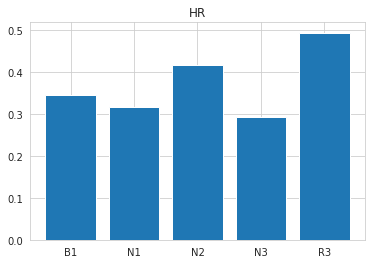

In [130]:
%matplotlib inline
plt.bar(list_model, list_HR)
plt.title('HR')

plt.show()

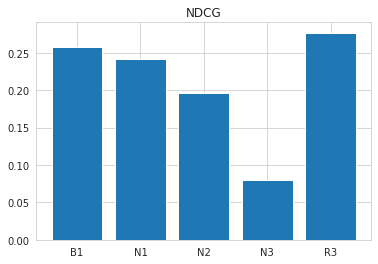

In [131]:
plt.bar(list_model, list_NDCG)
plt.title('NDCG')

plt.show()

In [118]:
table_result

,HR,NDCG
B1,0.3459,0.2584
N1,0.3158,0.2418
N2,0.4172,0.197
N3,0.293233,0.08
R3,0.494,0.277


The training of every model is taking more than 20 hours, so I only run one time with K=10 and Factors=16. It turns out that R3 is the best in both HR and NDCG, which is a referenced model - NeuMF implemented by the [3] reference on Github. Compared to my model, the referenced model used the torch library while my model is implemented from scratch. And there seems to be some errors in my impelmentations because the my implemented model is shallow and only have a few neurons in each layer. So my model is easier to overfit.
In the coding part, I learned how to implement NeuMF from scratch and with torch library. And what I learned in tackling recommendation problem is that combining two methods sometimes can give us better performance. In this case, we combined GMF and Neural Network, and it turns out that with the the processing of both high-level and low-level features, our result is more comprehensive and thus have better performance over HR and NDCG. This is very innovating because similar ideas were submitted in the field of Computer Vision in Object Dection tasks with YOLO. YOLO get three different sizes feature map by doing up-sampling after the feature extraction network. By doing object detection on those three levels, it has a better performance detecting different size object than its predecessor who use a fixed size feature map. This tells me that this idea of combining different level's feature can be applied to many fields, not just Recommendation Systems or Computer Vision.

